In [3]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 

## Directories

In [5]:
dataset = ['EFIFI','Nair'][1]
basedir = '../../bf_data/Nair_and_Abraham_2010/'
fitsdir = basedir + 'fits_final/'

out_dir = basedir+'out_final/'
fns_r = glob(fitsdir+"*/*r.fits")
fns_r.sort()
print("Number of fits files to process", len(fns_r))

Number of fits files to process 14034


# Generate mask

원래는 StatMorph가 안 돌아갈 경우 이미지에 문제가 있는 것으로 보았고 (거의 맞았음), 추가로 visual inspection 수행했음. 
-> 주변에 별이 있거나 companion 은하가 있으면 다 걸러냄. 

In [6]:
from astrobf.utils import gen_mask
from astrobf.morph import measure_morph

ValueError: not enough values to unpack (expected 3, got 2)

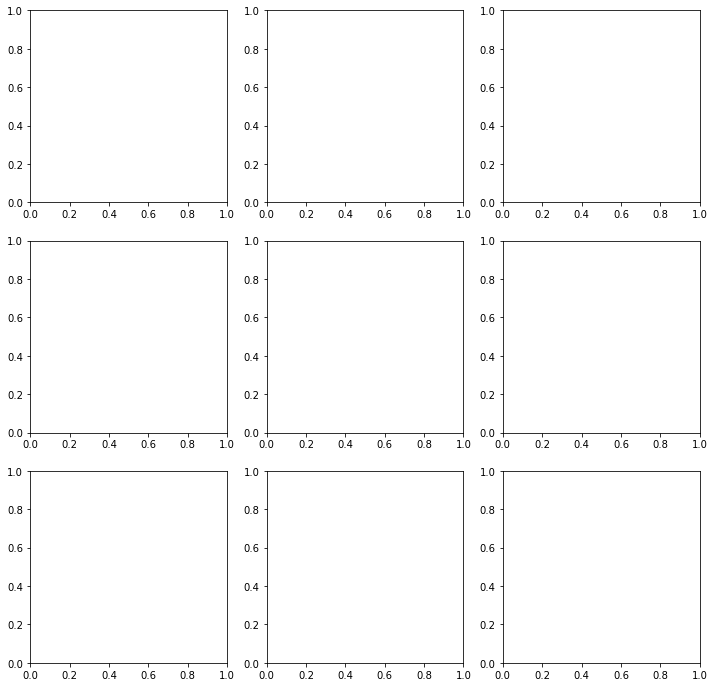

In [3]:
gen_mask.run_mask(fns_r, out_dir, npix_min=40)

안 돌지만.. 일단 못 본척. 

# Visual inspection - Filter out bad samples
Keep good samples.
Leave good galaxies (under `.../stat_png/good/*.png`) or list bad galaxies (in trash bin).

적당히 수동으로 리스트 작성. 

In [7]:
partially_filtered = "../../bf_data/Nair_and_Abraham_2010/Intermediate_files/final_150000_done.txt"
partial_bad = "../../bf_data/Nair_and_Abraham_2010/Intermediate_files/final_bad_gal_list.txt"

In [35]:
def gids_from_pnglist(plist):
    """
    Parameters
    ----------
        plist : list of png file names
    """
    gids=[]
    for ll in plist:
        gids.append(ll.split('_')[1])
        
    return gids

In [42]:
with open(partial_bad, 'r') as fbad:
    bad = gids_from_pnglist(fbad.readlines())
    
with open(partially_filtered, 'r') as ff:
    temp = gids_from_pnglist(ff.readlines())

good = []

good_gids=[]
for gg in temp:
    if gg not in bad:
        good.append(gg)

In [41]:
print("The length of the final sample:", len(good))

9537

# Merge files to minimize I/O

Merge image, mask, and weights + meta data (name, cutout slice and t-type)

In [50]:
from glob import glob
data_dir = '../../bf_data/Nair_and_Abraham_2010/'

fits_fns = glob(data_dir+'fits_final/*/*-r.fits')
weights_fns = glob(data_dir+'fits_final/*/*-r.weight.fits')
mask_fns = glob(data_dir+'final_all_masks/*_mask.pickle')

assert len(mask_fns) == len(fits_fns) == len(weights_fns)

In [65]:
# Make sure three data sets are in the same order
mask_fns.sort()
fits_fns.sort()
weights_fns.sort()

for fn_fits, fn_weight, fn_mask in zip(fits_fns, weights_fns, mask_fns):
    img_name1 = fn_fits.split("/J")[-2] 
    img_name2 = fn_weight.split("/J")[-2] 
    img_name3 = fn_mask.split("/J")[-1].split('_')[0] # mask names are slightly different
    assert img_name1 == img_name2 == img_name3


## Calculate Asym_center
언제 어디서 이걸 계산했던걸까...?? 

## Shift the images

recenter images.

In [7]:
from scipy.ndimage import shift

def recenter(img, mask, weight, asym_center):
    """
    shift images and return stacked array
    """
    return np.stack((shift(img,    np.array(img.shape)/2. - asym_center[::-1]),
                     shift(mask,   np.array(img.shape)/2. - asym_center[::-1]),
                     shift(weight, np.array(img.shape)/2. - asym_center[::-1])))

In [85]:
# merge three dataset into one. 
# make cutout to save storage space
from astropy.io import fits
import pickle
from astrobf.utils import mask_utils



###!!!!!!!!!!!!!!!!!!!!!!!!
## Asym_center 계산해올것!
## t-type도 가져올 것.


all_good=[]
for fn_fits, fn_weight, fn_mask in zip(fits_fns, weigths_fns, mask_fns):
    img_name = "J"+fn_fits.split("/J")[-2] 
    if img_name in good:
        img = fits.open(fn_fits)[0].data
        weight = fits.open(fn_weight)[0].data
        mask = pickle.load(open(fn_mask, 'rb'))
        slices = mask_utils._get_stamp_range(mask)
        data = recenter(img[slices], mask[slices], weight[slices], asym_center) ### warning.
        all_good.append({'data':data, 'img_name':img_name, 'slices':slices, 'tt':t_type})

pickle.dump(all_good, open("all_gals_centered.pickle", "wb"))

# 아래 참조하여 t-type 가져오기.

In [ ]:
# Catalog of StatMorph properties of the good sample.
from astrobf.utils.measure_morph import statMorph_fields
fields = statMorph_fields[:6]
ngal = len(good_gids)
result_arr = np.zeros(ngal, 
                      dtype=[('id','<U24'),('ttype',int),('flag',bool),('flag_sersic',bool)]
                           +[(ff,float) for ff in fields])
i=0
for alm in all_morphs:
    mps = pickle.load(open(alm,'rb'))
    for morph in mps:
        if morph._gid in good_gids:
            result_arr[i]['id'] = morph._gid
            for ff in fields:
                result_arr[i][ff] = getattr(morph, ff)
            i+=1
        else:
            pass

# t-types from catalog

Nair catalog has very specific and inconvenient format. You need a dedicated function for this.

In [168]:
cat = utils.misc.load_Nair('../../bf_data/Nair_and_Abraham_2010/catalog/table2.dat')

inds = cat['ID'].searchsorted(result_arr['id'])
print("Is every element matched?: ", np.all(cat[inds]['ID'] == result_arr['id']))
result_arr['ttype'] = cat[inds]['TT']

# Save the complete catalog
pickle.dump(result_arr, open(out_dir+'result_arr.pcikle', 'wb'))

AttributeError: module 'astrobf.utils' has no attribute 'misc'